## Advanced Lane Finding Project
Mon 13-Jul-2020  
John Hilbun

# This is based off example.ipynb

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### Step 1. Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

#%pylab inline
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(5000)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera (objpoints, imgpoints, gray.shape[::-1], None, None)#

cv2.destroyAllWindows()

#### Step 2. Apply a distortion correction to raw images.

In [2]:
# This code pulled from 12. Correction for Distortion Quiz
# call this like : undistorted = cal_undistort (img, objpoints, imgpoints)

def cal_undistort(img, objpoints, imgpoints, mtx, dist): # added mtx, dist
    gray = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
    undist = cv2.undistort (img, mtx, dist, None, mtx)
    return undist

In [3]:
# Added to show a distortion corrected calibration image
for fname in images:
    img = cv2.imread(fname)
    forRubric = cv2.undistort (img, mtx, dist, None, mtx)
    #cv2.imshow('forRubric',forRubric)
    #cv2.waitKey(5000)

#### Step 3. Use color transforms, gradients, etc., to create a thresholded binary image

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
# This concept comes from 3. Applying Sobel
# call this like : grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    hls = cv2.cvtColor (img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    #print ("gray shape:{}".format(gray.shape))

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if (orient=='x'):
        sobel = cv2.Sobel (l_channel, cv2.CV_64F, 1, 0)
    elif (orient=='y'):
        sobel = cv2.Sobel (l_channel, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute (sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8 (255*abs_sobel / np.max (abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like (scaled_sobel)
    binary_output [ (scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output


# This concept comes from 4. Magnitude of the Gradient
# call this like : mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel (gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel (gray, cv2.CV_64F, 0, 1)
    
    # 3) Calculate the magnitude
    magnitude = np.sqrt (np.square(sobelx)+np.square(sobely))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8 (255*magnitude / np.max (magnitude))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like (scaled_sobel)
    binary_output [ (scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1]) ] = 1

    # 6) Return this mask as your binary_output image
    return binary_output

# This concept comes from 5. Direction of the Gradient
# call this like : dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# in lesson, sobel_kernel=15 was used
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor (img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel (gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel (gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.abs (sobelx)
    abs_sobely = np.abs (sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    arctan = np.arctan2 (abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.uint8 (np.zeros_like (arctan))
    
    binary_output [ (arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output

In [6]:
# From Lesson 7. Gradient and Color Spaces : Lecture 10. HLS and Color Thresholds
def hls_threshold (image, thresh=(0,255)):
    hls = cv2.cvtColor (image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    # possibly add a check for H too
    binary[ (S > thresh[0]) & (S <= thresh[1]) | (L > thresh[0]) & (L <=thresh[1])] = 1
    return binary


#### Step 4. Apply a perspective transform to rectify binary image ("birds-eye view")

In [7]:
# This concept comes from:
# 14. Perspective Transform section
# 18. Undistort and Transform

#This might be in section 16. Transform a Stop Sign.
#I do not see explicit code for lane perspective transform, either:
#     - I missed it
#    or
#     - It's on purpose because this is part of the 'core' of the project
#    ?
# got these numbers by putting cursor over the stop sign image and writing down the x, y coordinates

Minv = 0  # if I do warp (Minv) later, this needs to be global.

def pTransform (image, direction='W'):
    global Minv
    
    # based off code from Mentor Shmuel N in Knowledge.
    # https://knowledge.udacity.com/questions/227358
    img_size = (image.shape[1], image.shape[0])
    
    src = np.float32 (
        [
            [ (img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [ ((img_size[0] / 6) - 10), img_size[1] ],
            # JDH SUN [ (img_size[0] * 5/6) + 60, img_size[1] ],
            [ (img_size[0] * 5/6) + 10, img_size[1] ], # JDH SUN
            [ (img_size[0] / 2 + 55), img_size[1] / 2 + 100]
        # JDH values from https://knowledge.udacity.com/questions/22331
        #    [674,440],   # upper right 674, 440
        #    [1048, 681], # lower right 1048, 681
        #    [277, 681],  # lower left 277, 681
        #    [610, 440]   # upper left 610, 440
        ])

    # eyeball the x, y coordinate we’d like the stop sign to end up  on:
    dst = np.float32 ( [
    #        [577, 0],   # [ (img_size[0] / 4), 0],                 # [577, 0],
    #        [577, 719], # [ (img_size[0] / 4), img_size[1] ],      # [577, 719],
    #        [703, 719], # [ (img_size[0] * 3/4), img_size [1] ],   # [703, 719],
    #        [703, 0]    # [ (img_size[0] * 3/4), 0]                # [703, 0]
    # another try:
    #            [ (img_size[0] / 4), 0 ],
    #            [ (img_size[0] / 4), img_size[1] ],
    #            [ (img_size[0] * 3/4), img_size[1] ],
    #            [ (img_size[0] * 3/4), 0]
    # values from Mentor Shmuel N in Knowledge (reference above)
        #[240,719],
        #[240,0],
        #[1000,0],
        #[1000,719]
        # values from https://knowledge.udacity.com/questions/22331
        [1000,0],
        [1000,719],
        [280,719],
        [280,0]
    ])
    
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform (src, dst)

    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform (dst, src)
    
    if (direction == 'W'):  # warp the image
        # Warp an image using the perspective transform, M:
        warped = cv2.warpPerspective (image, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        # Unwarp an image using the perspective transform, Minv:
        warped = cv2.warpPerspective (image, Minv, img_size, flags=cv2.INTER_LINEAR)      

    return warped

#### Step 5. Detect lane pixels and fit to find the lane boundary

In [8]:
# This concept comes from 4. Finding the Lines: Sliding Window

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Sum each column of the image, top to bottom. The idea is that lanes are more aligned top to bottom.
    # So more pixels in a column more likely indicates a lane.

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) *255
    # dstack lets us have an RGB image. binary_warped.shape:(720, 1280) out_img.shape(720, 1280, 3)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9

    # Set the width of the windows +/- margin
    margin = 100 # Have been using 50

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()   # x,y position of nonzero pixels in binary_warped
    nonzeroy = np.array(nonzero[0])     # just the x values
    nonzerox = np.array(nonzero[1])     # just the y values

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Debug Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        # ?_lane_inds hold the pixel values contained within the boundaries of a given sliding window.
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds > minpix):
            leftx_current = np.int (np.mean (nonzerox[good_left_inds]))
        if len(good_right_inds > minpix):
            rightx_current = np.int (np.mean (nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [9]:
# From Tips and Tricks
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = [] # original None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

LeftSanity = Line()
RightSanity = Line()

In [10]:
# Sanity check
# https://knowledge.udacity.com/questions/31188
def Sane(lefty, righty):
    middle = 360
    bottom = 719
    
    if ((righty[middle] - lefty[middle]) > 1.0) & ((righty[bottom] - lefty[bottom]) > 1.0): # 1.5 OK?
        return True
    else:
        #print ("Sane: found insane value")
        return False


In [11]:
# This concept comes from 4. Finding the Lines: Sliding Window

def fit_polynomial(binary_warped, image):
    global LeftSanity
    global RightSanity
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    # https://knowledge.udacity.com/questions/18801
    ym_per_pix = 30/720
    xm_per_pix = 3.7/720
    left_fit = np.polyfit (lefty, leftx, 2)     # was (leftx, lefty, 2)
    right_fit = np.polyfit (righty, rightx, 2) # was (rightx, righty, 2)
    
    #print ("left_fit: {} {} {}".format(left_fit[0], left_fit[1], left_fit[2]))
    #print ("right_fit: {} {} {}".format(right_fit[0], right_fit[1], right_fit[2]))
    
    # Repeat for real world values (not pixels) - for use in a later function
    left_fit_real = np.polyfit (lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_real = np.polyfit (righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    # from 0 to 719, 720 lines
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a polynomial!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # This will show where lane lines were detected.
    out_img[lefty, leftx] = [255, 0, 0] # I'm assuming use RGB here.
    out_img[righty, rightx] = [0, 0, 255]
    
    # swap x,y and this change from https://knowledge.udacity.com/questions/228831
    # to show the green boxes and calculated polynomial lines:
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0,1280)
    #plt.ylim(720,0)
    #plt.show()

    # From Tips and Tricks
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # smooth out the line
    n = 24  # keep track of last n fits
    LeftSanity.current_fit.append(left_fit)
    if (len (LeftSanity.current_fit) > n):
        LeftSanity.current_fit.pop(0)
        # LeftSanity.best_fit = np.average(LeftSanity.current_fit, axis=0, weights=[0.2, 0.2, 0.2, 0.2, 0.2])
        LeftSanity.best_fit = np.average(LeftSanity.current_fit, axis=0)
    else:
        LeftSanity.best_fit = np.average(LeftSanity.current_fit)
    
    RightSanity.current_fit.append(right_fit)
    if (len (RightSanity.current_fit) > n):
        RightSanity.current_fit.pop(0)
        # RightSanity.best_fit = np.average(RightSanity.current_fit, axis=0, weights=[0.2, 0.2, 0.2, 0.2, 0.2])
        RightSanity.best_fit = np.average(RightSanity.current_fit, axis=0)
    else:
        RightSanity.best_fit = np.average(RightSanity.current_fit)

    # Keep the previous code the same
    left_fit = LeftSanity.best_fit
    right_fit = RightSanity.best_fit
    
    # smoothing
    if (len(LeftSanity.bestx)): # if there is an average already
        if True: # JDH MON smooth Sane(lefty, righty):
            LeftSanity.detected = True
            LeftSanity.bestx.append(left_fitx)  # add the new value to the list
            if (len(LeftSanity.bestx) > n):
                LeftSanity.bestx.pop(0)
                # left_fitx = np.average(LeftSanity.bestx, axis=0, weights=[0.2, 0.2, 0.2, 0.2, 0.2])
                left_fitx = np.average(LeftSanity.bestx, axis=0)
            else:
                left_fitx = np.average(LeftSanity.bestx, axis=0)                
        else:
            LeftSanity.detected = False
    else: # else there is no average so use the first value
        LeftSanity.detected = True
        LeftSanity.bestx.append(left_fitx)
        left_fitx = np.average(LeftSanity.bestx, axis=0)                
        
    if (len(RightSanity.bestx)): # if there is an average already
        if True: # JDH MON smooth Sane(lefty, righty):
            RightSanity.detected = True
            RightSanity.bestx.append(right_fitx)  # add the new value to the list
            if (len(RightSanity.bestx) > n):
                RightSanity.bestx.pop(0)
                # right_fitx = np.average(RightSanity.bestx, axis=0, weights=[0.2, 0.2, 0.2, 0.2, 0.2])
                right_fitx = np.average(RightSanity.bestx, axis=0)
            else:
                right_fitx = np.average(RightSanity.bestx, axis=0)                
        else:
            RightSanity.detected = True
    else: # else there is no average so use the first value
        RightSanity.detected = True
        RightSanity.bestx.append(right_fitx)
        right_fitx = np.average(RightSanity.bestx, axis=0)                
        
    color_warp[lefty, leftx] = [0, 255, 0]
    color_warp[righty, rightx] = [0, 255, 255]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines (color_warp, np.int_([pts_left]), False, (255,0,0), thickness=5)
    cv2.polylines (color_warp, np.int_([pts_right]), False, (0,0,255), thickness=5)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    # demo code puts this here. I do it later. Keep commented out for now.
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 0.9, newwarp, 0.9, 0) 
    
    # ?_fitx : the individual x values of the polynomial
    # ?_fit : the coefficients of the polynomials
    return result, left_fitx, right_fitx, left_fit_real, right_fit_real, ploty


In [12]:
# First cut at improving efficiency - search line from prior
# This is prev_poly.py in Lesson 8. Advanced Computer Vision
# - Lecture 5. Finding the Lines, Searching from prior

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    global LeftSanity
    global RightSanity
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    ym_per_pix = 30/720
    xm_per_pix = 3.7/720
    left_fit = np.polyfit (lefty, leftx, 2)
    right_fit = np.polyfit (righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    # smooth out the line
    n = 24  # keep track of last n fits
    LeftSanity.current_fit.append(left_fit)
    if (len (LeftSanity.current_fit) > n):
        np.delete (LeftSanity.current_fit,0)
    LeftSanity.best_fit = np.mean(LeftSanity.current_fit)
    RightSanity.current_fit.append(right_fit)
    if (len (RightSanity.current_fit) > n):
        np.delete (RightSanity.current_fit,0)
    RightSanity.best_fit = np.average(RightSanity.current_fit, [.30, .30, .40])

    # Keep the previous code the same
    left_fit = LeftSanity.best_fit
    right_fit = RightSanity.best_fit
    
    # ?_fitx : the individual x,y values of the polynomial
    # ?_fit : the coefficients of the polynomials
    return left_fitx, right_fitx, left_fit, right_fit, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # binary_warped : the image
    # left_fit : previously determined polynomial values
    # right_fit : previously determined polynomial values
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, left_fit, right_fit, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    ym_per_pix = 30/720
    xm_per_pix = 3.7/720
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty

#### Step 6. Determine the curvature of the lane and vehicle position with respect to center

In [13]:
# From Measure Curvature II
def measure_curvature_real(ploty, left_fit_real_cr, right_fit_real_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_real_cr[0]*y_eval*ym_per_pix + left_fit_real_cr[1])**2)**1.5) / np.absolute(2*left_fit_real_cr[0])
    right_curverad = ((1 + (2*right_fit_real_cr[0]*y_eval*ym_per_pix + right_fit_real_cr[1])**2)**1.5) / np.absolute(2*right_fit_real_cr[0])

    return left_curverad, right_curverad


In [14]:
# This concept comes from 5. Finding the Lines: Search from Prior (?)

def curve_and_position (left_fitx, right_fitx, left_fit_real, right_fit_real, ploty):
    # _left is the fit polynomial value at the bottom of the image
    xright = np.int(right_fitx[len(right_fitx)-1])
    xleft = np.int(left_fitx[len(left_fitx)-1])
    half_lane_size = (xright - xleft)//2 
    lane_center = xleft + half_lane_size
    
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fit_real, right_fit_real)

    return lane_center, left_curverad, right_curverad


https://knowledge.udacity.com/questions/163276
If we are in birdseye view, have to make sure the warp didn't change vertical centerline.
half_length = (right lane x value - left lane x value) / 2
centerOfLane = left lane x value + half length

https://knowledge.udacity.com/questions/26056

Warp values:
https://knowledge.udacity.com/questions/22331
    
Curvature related:
https://knowledge.udacity.com/questions/6385
    
Lane length:
https://knowledge.udacity.com/questions/16375
    
Radius of curvature:
https://knowledge.udacity.com/questions/56120

Radius of curvature:
https://knowledge.udacity.com/questions/29265



#### Step 7. Warp the detected lane boundaries back onto the original image

In [15]:
# This concept comes from 5. Finding the Lines: Search from Prior (?)
# out_img (?)

#### Step 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [16]:
# This concept comes from 6. Measuring Curvature I and II (?)

# Review '2. Tips and Tricks for the Project'. Might have helpful info, including how to
# fill in the entire detected lane with color ('Drawing' section).

#Display text on video:
#https://knowledge.udacity.com/questions/29906

def overlay_data (image, lane_center, left_curverad, right_curverad):
    # image.shape[0] is height
    # image.shape[1] is width
    xm_per_pix = 30/720
    image_center = (image.shape[1] // 2)
    offset = (image_center - lane_center)
    if offset > 0:
        direction = "left"
    else:
        direction = "right"
        offset = np.abs(offset)
    xm_per_pix = 3.7/720 # meters per pixel in x dimension : pTransform ~60%
    offset = offset * xm_per_pix
    text = "Vehicle is {:3.2f}m {} of center".format(offset, direction)
    cv2.putText (image, text, org=(325,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255))
    text = "Left curve is {:9.2f} : Right curve is {:9.2f}".format(left_curverad, right_curverad)
    cv2.putText (image, text, org=(75,75), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255))
    return image

#### Now process on videos

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def draw_lane_surface (image):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([50,51,52,53,54,55,56,57,58,59,60])
    pts_right = np.array([50,51,52,53,54,55,56,57,58,59,60])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    # result = cv2.addWeighted(image, 1, colorwarp, 0.3, 0)
    result = cv2.addWeighted(image, 0.8, colorwarp, 1., 0.)  # from Project1 : α=0.8, β=1., γ=0.
    
    return result


In [19]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ, dtype=cv2.CV_64F)


#### Pipeline

In [20]:
def pipeline (img):
    # Step 2: Apply a distortion correction to raw images
    undist = cal_undistort (img, objpoints, imgpoints, mtx, dist)

    # narrow the image to only the area we care about
    # region of interest
    min_height = undist.shape[0] * .60
    max_height = undist.shape[0]
    width = undist.shape[1]
    w1 = width * .11  # emperical value : used .10 in Project 1
    w2 = width * .43  # emperical value : used .44 in Project 1
    w3 = width * .58  # emperical value : used .60 in Project 1
    w4 = width * .99  # emperical value : used .99 in Project 1
    vertices = np.array([[w1, max_height], [w2, min_height], [w3, min_height], [w4, max_height]], dtype=np.int32)

    # Step 3. Use color transforms, gradients, etc., to create a thresholded binary image
    # This concept comes from 6. Combining Thresholds
    # choose a Sobel kernel size
    ksize = 9  # choose a larger odd number to smooth gradient measurements
    gradx = abs_sobel_thresh (undist, orient='x', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    # cv2.imshow('gradx',gradx)
    # cv2.waitKey(1000)
    # cv2.destroyAllWindows()
    # plt.imshow (gradx, cmap='gray')
    # plt.title ("pipeline - gradx")
    # plt.show()
    
    grady = abs_sobel_thresh (undist, orient='y', sobel_kernel=ksize, thresh_min=20, thresh_max=100)
    #cv2.imshow('grady',grady)
    #cv2.waitKey(1000)
    #cv2.destroyAllWindows()
    # plt.imshow (grady, cmap='gray')
    # plt.title ("pipeline - grady")
    # plt.show()
    
    mag_binary = mag_thresh (undist, sobel_kernel=ksize, mag_thresh=(30, 100))
    #cv2.imshow('mag_binary',mag_binary)
    #cv2.waitKey(1000)
    #cv2.destroyAllWindows()
    # plt.imshow (mag_binary, cmap='gray')
    # plt.title ("pipeline - mag_binary")
    # plt.show()
    
    dir_binary = dir_threshold (undist, sobel_kernel=ksize, thresh=(0.7, 1.3))
    #cv2.imshow('dir_binary',dir_binary)
    #cv2.waitKey(1000)
    #cv2.destroyAllWindows()
    # plt.imshow (dir_binary, cmap='gray')
    # plt.title ("pipeline - dir_binary")
    # plt.show()
    
    #print ("dir_binary shape:{}".format(dir_binary.shape))
    # Try different combinations and see what you get.
    # For example:
    # where is a selection for pixels where both the x and y gradients meet the threshold criteria
    # or
    # the gradient magnitude and direction are both within their threshold values.
    
    # Changing values looking at smoothing.
    hls_binary = hls_threshold (undist, thresh=(170, 255)) # lessons showed (90,255) and (170,255)
    
    combined = np.uint8(np.zeros_like (dir_binary))
    
    combined [ ((hls_binary==1) | ((gradx==1) & (grady == 1) ) | (( mag_binary == 1) & (dir_binary == 1) )) ] = 1
    # (Lesson 7 : Lecture 12)
    
    #print ("combined shape:{} combined.dtype:{}".format(combined.shape, combined.dtype))
    # combined is a b&w pixel representation of where we saw lane lines : only in the trapezoid of interest.
    #cv2.imshow('combined',combined)
    #cv2.waitKey(1000)
    #cv2.destroyAllWindows()
    #plt.imshow (combined, cmap='gray')
    #plt.title ("pipeline - combined / gray")
    #plt.show()

    # Step 4. Apply a perspective transform to rectify binary image ("birds-eye view")
    #cv2.imshow('combined',combined)
    #cv2.waitKey(2000)

    # moved mask to be after binary images to get rid of trapezoid edges detected as lane lines
    masked_image = region_of_interest (combined, [vertices])
    #print ("masked_image shape:{} masked_image.dtype:{}".format(masked_image.shape, masked_image.dtype))
    #cv2.imshow('masked_image',masked_image)
    #cv2.waitKey(1000)
    #cv2.destroyAllWindows()
    # plt.imshow (masked_image, cmap='gray')
    # plt.title ("pipeline - masked / gray")
    # plt.show()

    warped_img = pTransform (masked_image, 'W') # 'W' means warped
    #print ("warped_img shape:{}".format(warped_img.shape))
    # warped_img contains the BirdsEye detected lane lines and b&w pixel image. Black everywhere else...
    # except, you can see the 'cone' of the trapezoid showing up as lane lines on the left and right.
    #plt.title ("rubric:warped")
    #plt.imshow (warped_img)
    #plt.figure()
    
    # Step 5. Detect lane pixels and fit to find the lane boundary
    # birds_eye_binary_with_lane_lines = fit_polynomial(warped_img, img)
    
    # print ("warped_img.shape:{}".format (warped_img.shape))
    
    # if no existing polynomial:
    combo, left_fitx, right_fitx, left_fit_real, right_fit_real, ploty = fit_polynomial(warped_img, img)
    # else:
    # left_fitx, right_fitx, left_fit, right_fit, ploty = fit_poly (warped_img, left_fit, right_fit)
    
    
    # the biggest problem starts here. Gibberish for the green trapezoid.
    # Possible:
        # it's showing left/right instead of up/down. That's one issue.
        # it seems like the fitpoly's are not very good. That would seem to be because of bad pixel detection...
        # I'd say fit_polynomial is START HERE.
    #print ("pipeline() combo.shape:{} combo.dtype:{}".format(combo.shape, combo.dtype))
    #cv2.imshow('combo',combo)
    #cv2.waitKey(1000)
    # plt.title ("combo")
    # plt.imshow (combo)
    # plt.show()
    # plt.imshow(out_img)

    # Step 6. Determine the curvature of the lane and vehicle position with respect to center
    lane_center, left_curverad, right_curverad = curve_and_position (left_fitx, right_fitx, left_fit_real, right_fit_real, ploty)
    
    # Step 7. Warp the detected lane boundaries back onto the original image
    # camera_eye_binary_with_lane_lines = pTransform (birds_eye_binary_with_lane_lines, 'U') # anything other than 'W' means unwarp
    
    # Step 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position
    # combo = weighted_img(camera_eye_binary_with_lane_lines, img, α=0.5, β=1., γ=0.)
    # combo = weighted_img(camera_eye_binary_with_lane_lines, img, α=.8, β=1., γ=0.)
    combo = overlay_data (combo, lane_center, left_curverad, right_curverad)

    return combo


In [21]:
# This is cut&paste from 1st project. Do values make sense?
# It seems like this should invoke all the work that was done above (per image)
# So the 'pipeline' becomes the sequence of events in 'process_image' ?

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    result = pipeline (image)
    #plt.title ("process_image():after")
    #plt.imshow (image)
    #plt.figure()

    return result

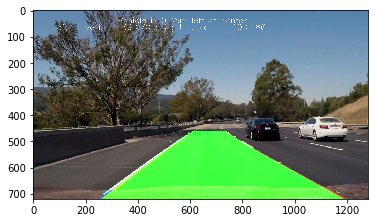

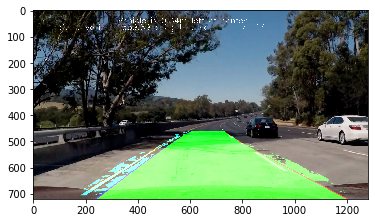

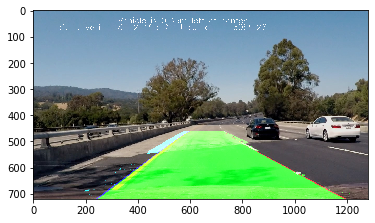

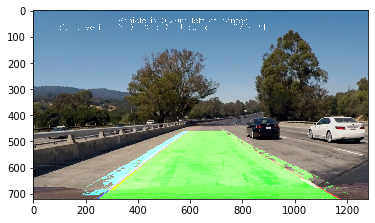

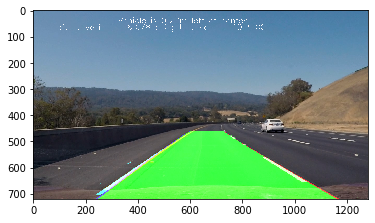

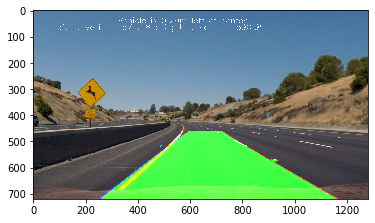

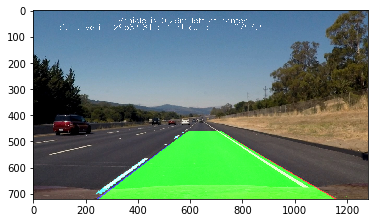

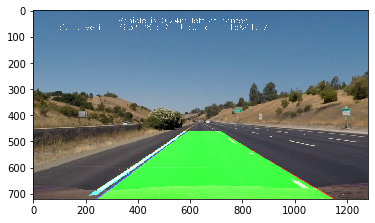

In [22]:
# Debug - look at one image
images = glob.glob('../test_images/*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    image = plt.imread(fname)
    result = pipeline (image)
    #print ("result:{}".format(result.shape))
    plt.imshow(result)
    plt.show()


#### Now Process Videos:

In [23]:
project_output = '../output_images/project_results.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# JDH submission video : clip1 = VideoFileClip("../project_video.mp4")
clip1 = VideoFileClip("../project_video.mp4")
#clip1 = VideoFileClip("../project_video_trim_15.mp4")
#clip1 = VideoFileClip("../project_video_trim_7.mp4")
#clip1 = VideoFileClip("../project_video_trim_5.mp4")
#clip1 = VideoFileClip("../project_video_trim_4.mp4")
#clip1 = VideoFileClip("../project_video_trim_1.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../output_images/project_results.mp4.
Moviepy - Writing video ../output_images/project_results.mp4



Moviepy - Done !
Moviepy - video ready ../output_images/project_results.mp4
CPU times: user 8min 10s, sys: 1min 5s, total: 9min 16s
Wall time: 4min 56s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))